In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 3.3.1
Uninstalling lightgbm-3.3.1:
  Successfully uninstalled lightgbm-3.3.1
  Using cached lightgbm-3.3.1-py3-none-manylinux1_x86_64.whl (2.0 MB)


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 3
    n_geographic_split = 48
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by latlon_section')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('latlon_section')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest', 'fold']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
            
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
## Data split
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(data, 
                                                data['point_of_interest'], 
                                                data['point_of_interest'])):
    data.loc[val_idx, 'set'] = i

print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

valid_data = data[data['set'] == 0]
train_data = data[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Valid data: ')
analysis(valid_data)

train_poi = train_data['point_of_interest'].unique().tolist()
valid_poi = valid_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(valid_poi))

train_ids = train_data['id'].unique().tolist()
valid_ids = valid_data['id'].unique().tolist()
      
print(set(train_ids) & set(valid_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['valid_ids'] = valid_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, valid_data
gc.collect()

data = data.set_index('id')
# data = data.loc[tv_ids_d['train_ids']]
data = data.reset_index()

Num of train data: 1138812
1.0    569406
0.0    569406
Name: set, dtype: int64
Train data: 
Num of data: 569406
Num of unique id: 569406
Num of unique poi: 369987
Mean num of unique poi: 1.5389892077289202
Valid data: 
Num of data: 569406
Num of unique id: 569406
Num of unique poi: 369985
Mean num of unique poi: 1.5389975269267673
set()
set()


#Add new geographic coordinate classification

In [ ]:
latitude = [-90 + 180 / (CFG.n_geographic_split // 2) * i for i in range(1, CFG.n_geographic_split // 2)]
longitude = [-180 + 360 / CFG.n_geographic_split * i for i in range(CFG.n_geographic_split)]

In [ ]:
latlons = [(lat, lon) for lon in longitude for lat in latitude]
latlons.append((-90, 0))
latlons.append((90, 0))

In [ ]:
!pip install haversine
from haversine import haversine, Unit

In [ ]:
def latlon_section(latlon):
    min_distance = float('inf')
    min_latlon = None
    for i in range(len(latlons)):
        distance = haversine(latlons[i], latlon)
        if distance < min_distance:
            min_distance = distance
            min_latlon = i
    return min_latlon
data['latlon_section'] = data[['latitude', 'longitude']].apply(latlon_section, axis = 1)
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,set,latlon_section
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1.0,570
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,0.0,422
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0.0,864
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0.0,660
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,0.0,546


<BarContainer object of 402 artists>

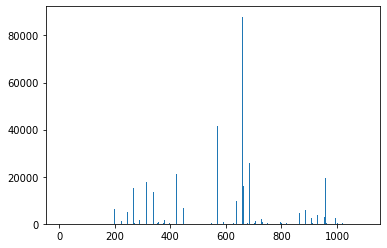

In [ ]:
plt.bar(data['latlon_section'].value_counts().index, data['latlon_section'].value_counts())

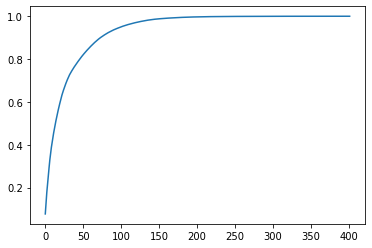

In [ ]:
counts = np.array(data['latlon_section'].value_counts())
counts_sum = counts.sum()
counts = np.sort(counts)[::-1]
plt.plot(np.arange(len(counts)), np.cumsum(counts) / counts_sum)

# split fold

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,set,latlon_section,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1.0,570,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,0.0,422,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0.0,864,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0.0,660,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,0.0,546,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=CFG.num_split, seed=CFG.SEED)):
    data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - fold 0,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - fold 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - fold 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - fold 1,37.32%,48.77%,6.38%,2.09%,5.44%
development set - fold 2,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - fold 2,37.32%,48.77%,6.38%,2.09%,5.44%


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tv_fit = tfidf.fit_transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = pd.concat([
    recall_knn(data[data["set"]==0], CFG.num_neighbors), 
    recall_knn(data[data["set"]==1], CFG.num_neighbors), 
])

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by latlon_section


  0%|          | 0/359 [00:00<?, ?it/s]

Start knn
Start knn grouped by latlon_section


  0%|          | 0/370 [00:00<?, ?it/s]

Start knn
Num of unique id: 1138812
Num of train data: 26547193
Pos rate: 0.07581618892814769
                        id          match_id     kdist  kneighbors  \
9317932   E_5d4bbb74b832a3  E_5fcfb0cda301a7  0.012050        16.0   
4967123   E_b8e4245de6f86e  E_3e9ada75d51b19  0.001570         8.0   
8513743   E_f3a8ef3d48d6bb  E_cf00608aac695c  0.025700        14.0   
8152638   E_514c1a2f58c3d2  E_50eb1129f0fd8c  0.000277        14.0   
11506127  E_3cd471907da4ec  E_c38fa0d93ab8ac       NaN         NaN   

         point_of_interest  fold  kdist_country  kneighbors_country  label  
9317932                NaN   NaN            NaN                 NaN      0  
4967123                NaN   NaN            NaN                 NaN      0  
8513743                NaN   NaN            NaN                 NaN      0  
8152638   P_124f2f561ae068   2.0       0.000277                14.0      0  
11506127  P_53e76f8760fc4f   2.0       0.491857                19.0      0  


In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9227820824079624


# model learning

In [ ]:
data = data.set_index('id')
# train_data = add_features(train_data)

In [ ]:
train_data['kdist_diff'] = (train_data['kdist'] - train_data['kdist_country']) /\
                            train_data['kdist_country']
train_data['kneighbors_mean'] = train_data[['kneighbors', 'kneighbors_country']].mean(axis = 1)

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), 2), dtype=np.float64)
    
    for i in tqdm(range(CFG.num_split)):
        print(f"== fold {i} ==")
        trn_idx = folds==(i-i)%CFG.num_split
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
        X_train = add_features(X_train)
        X_valid = add_features(X_valid)
        X_train = X_train[features]
        X_valid = X_valid[features]

        if model_dir is None:
            model = lgb.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='binary',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

        del X_train, X_valid
        gc.collect()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data, train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      N_SPLITS=CFG.num_split, folds=train_data["fold"].values)

  0%|          | 0/3 [00:00<?, ?it/s]

== fold 0 ==


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.049047
[100]	valid_0's binary_logloss: 0.0466243
[150]	valid_0's binary_logloss: 0.0452859
[200]	valid_0's binary_logloss: 0.0441004
[250]	valid_0's binary_logloss: 0.0432031
[300]	valid_0's binary_logloss: 0.0423446
[350]	valid_0's binary_logloss: 0.0416619
[400]	valid_0's binary_logloss: 0.0410378
[450]	valid_0's binary_logloss: 0.040339
[500]	valid_0's binary_logloss: 0.0397703
[550]	valid_0's binary_logloss: 0.0391832
[600]	valid_0's binary_logloss: 0.0387116
[650]	valid_0's binary_logloss: 0.0382267
[700]	valid_0's binary_logloss: 0.0377017
[750]	valid_0's binary_logloss: 0.0372169
[800]	valid_0's binary_logloss: 0.0367649
[850]	valid_0's binary_logloss: 0.0363351
[900]	valid_0's binary_logloss: 0.0358898
[950]	valid_0's binary_logloss: 0.0354436
[1000]	valid_0's binary_logloss: 0.0350605
[1050]	valid_0's binary_logloss: 0.0346654
[1100]	valid_0's binary_logloss: 0.0342352
[1150]	valid_0's binary_logloss: 0.0338717
[1200]	valid_0's binary_logloss: 

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0509219
[100]	valid_0's binary_logloss: 0.0494535
[150]	valid_0's binary_logloss: 0.048905
[200]	valid_0's binary_logloss: 0.0484262
[250]	valid_0's binary_logloss: 0.0482197
[300]	valid_0's binary_logloss: 0.0479915
[350]	valid_0's binary_logloss: 0.0478926
[400]	valid_0's binary_logloss: 0.0477743
[450]	valid_0's binary_logloss: 0.0476369
[500]	valid_0's binary_logloss: 0.0475922
[550]	valid_0's binary_logloss: 0.0475228
[600]	valid_0's binary_logloss: 0.0475046
[650]	valid_0's binary_logloss: 0.0474649
[700]	valid_0's binary_logloss: 0.047395
[750]	valid_0's binary_logloss: 0.0473572

== fold 2 ==


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0514477
[100]	valid_0's binary_logloss: 0.0500637
[150]	valid_0's binary_logloss: 0.0495418
[200]	valid_0's binary_logloss: 0.0491328
[250]	valid_0's binary_logloss: 0.048942
[300]	valid_0's binary_logloss: 0.0487421
[350]	valid_0's binary_logloss: 0.0486421
[400]	valid_0's binary_logloss: 0.0485361
[450]	valid_0's binary_logloss: 0.0483953
[500]	valid_0's binary_logloss: 0.0483649
[550]	valid_0's binary_logloss: 0.0482972

CV-accuracy: 0.9894663062870714


In [ ]:
train_data["pred"] = oof[:, -1]

In [ ]:
out_df = pd.DataFrame()
out_df['id'] = train_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']

#Check Feature Importances

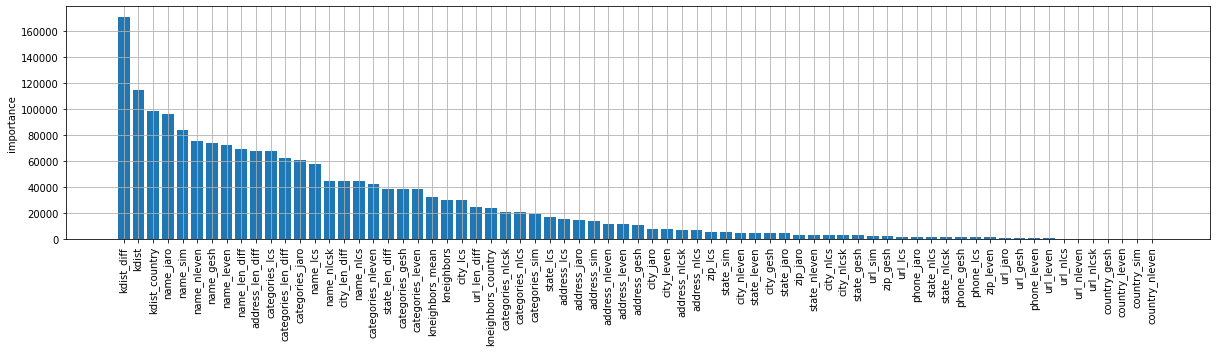

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
!pip install optuna

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    train_pred_df = train_data[train_data['pred'] > x][['id', 'match_id']]
    train_pred_df = train_pred_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    train_pred_df['matches'] = train_pred_df['match_id'].apply(lambda x: ' '.join(set(x)))
    train_pred_df = post_process(train_pred_df)
    score = get_score(train_pred_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-21 06:04:14,466] A new study created in memory with name: no-name-78fa0dd0-3f9b-44a0-b977-ac8f34dc68f9
[I 2022-05-21 06:04:54,018] Trial 0 finished with value: 0.8215055094381754 and parameters: {'threshold': 0.18753671172144548}. Best is trial 0 with value: 0.8215055094381754.


CV: 0.821506


[I 2022-05-21 06:05:25,161] Trial 1 finished with value: 0.8567102574429539 and parameters: {'threshold': 0.572052260513908}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.856710


[I 2022-05-21 06:05:57,856] Trial 2 finished with value: 0.8396862208959228 and parameters: {'threshold': 0.28423434101461753}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.839686


[I 2022-05-21 06:06:28,186] Trial 3 finished with value: 0.8351590156729641 and parameters: {'threshold': 0.8746959808305728}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.835159
CV: 0.819113


[I 2022-05-21 06:07:01,475] Trial 4 finished with value: 0.8191130823458366 and parameters: {'threshold': 0.17878801947886913}. Best is trial 1 with value: 0.8567102574429539.
[I 2022-05-21 06:07:32,575] Trial 5 finished with value: 0.8553007916923863 and parameters: {'threshold': 0.6730485436488346}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.855301


[I 2022-05-21 06:08:04,872] Trial 6 finished with value: 0.8545459900335225 and parameters: {'threshold': 0.4713627836284989}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.854546


[I 2022-05-21 06:08:36,589] Trial 7 finished with value: 0.8441625976162394 and parameters: {'threshold': 0.32052617713591536}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.844163


[I 2022-05-21 06:09:07,544] Trial 8 finished with value: 0.8561420512746888 and parameters: {'threshold': 0.6411128173089751}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.856142


[I 2022-05-21 06:09:39,265] Trial 9 finished with value: 0.8560759866685281 and parameters: {'threshold': 0.6445210261109056}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.856076


[I 2022-05-21 06:10:10,469] Trial 10 finished with value: 0.8088469603215216 and parameters: {'threshold': 0.9477330427202267}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.808847


[I 2022-05-21 06:10:41,640] Trial 11 finished with value: 0.8562572784472863 and parameters: {'threshold': 0.6333093562656428}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.856257


[I 2022-05-21 06:11:12,564] Trial 12 finished with value: 0.8548916683756914 and parameters: {'threshold': 0.48120878551226304}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.854892


[I 2022-05-21 06:11:46,362] Trial 13 finished with value: 0.8501851584137355 and parameters: {'threshold': 0.7655476813225007}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.850185


[I 2022-05-21 06:12:17,380] Trial 14 finished with value: 0.8561638484894807 and parameters: {'threshold': 0.5280044032988496}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.856164


[I 2022-05-21 06:12:56,224] Trial 15 finished with value: 0.578465269855359 and parameters: {'threshold': 0.008975833744581996}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.578465


[I 2022-05-21 06:13:26,751] Trial 16 finished with value: 0.8444383992486141 and parameters: {'threshold': 0.8206053741699975}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.844438


[I 2022-05-21 06:13:57,982] Trial 17 finished with value: 0.8565586417538174 and parameters: {'threshold': 0.5527473285039896}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.856559


[I 2022-05-21 06:14:28,005] Trial 18 finished with value: 0.8507403424619383 and parameters: {'threshold': 0.39643285270697604}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.850740


[I 2022-05-21 06:14:59,352] Trial 19 finished with value: 0.8563690749593103 and parameters: {'threshold': 0.5387176206028138}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.856369


[I 2022-05-21 06:15:30,376] Trial 20 finished with value: 0.8535775709210622 and parameters: {'threshold': 0.7154488085840096}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.853578


[I 2022-05-21 06:16:03,717] Trial 21 finished with value: 0.8566370932362937 and parameters: {'threshold': 0.5585246157081486}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.856637


[I 2022-05-21 06:16:34,279] Trial 22 finished with value: 0.8566448821767412 and parameters: {'threshold': 0.559461066272235}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.856645


[I 2022-05-21 06:17:05,986] Trial 23 finished with value: 0.8516911531269657 and parameters: {'threshold': 0.410880613960958}. Best is trial 1 with value: 0.8567102574429539.


CV: 0.851691


[I 2022-05-21 06:17:37,622] Trial 24 finished with value: 0.8567854366868602 and parameters: {'threshold': 0.5785605392514817}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856785


[I 2022-05-21 06:18:08,287] Trial 25 finished with value: 0.8514954772530454 and parameters: {'threshold': 0.7487209156219321}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.851495


[I 2022-05-21 06:18:38,551] Trial 26 finished with value: 0.8566325730253267 and parameters: {'threshold': 0.6081492903168938}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856633


[I 2022-05-21 06:19:09,351] Trial 27 finished with value: 0.8503118836889051 and parameters: {'threshold': 0.38936017280641677}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.850312


[I 2022-05-21 06:19:39,445] Trial 28 finished with value: 0.8446528496949748 and parameters: {'threshold': 0.8190534925772931}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.844653


[I 2022-05-21 06:20:10,797] Trial 29 finished with value: 0.8303084467133328 and parameters: {'threshold': 0.22602372953288163}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.830308


[I 2022-05-21 06:20:41,839] Trial 30 finished with value: 0.8537968126166282 and parameters: {'threshold': 0.45191485744539794}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.853797


[I 2022-05-21 06:21:12,403] Trial 31 finished with value: 0.8566725913504993 and parameters: {'threshold': 0.5655676442375221}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856673


[I 2022-05-21 06:21:43,719] Trial 32 finished with value: 0.8567625714474404 and parameters: {'threshold': 0.582643280977299}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856763


[I 2022-05-21 06:22:14,056] Trial 33 finished with value: 0.8541051851893154 and parameters: {'threshold': 0.7048983487692942}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.854105


[I 2022-05-21 06:22:44,751] Trial 34 finished with value: 0.8448300091617371 and parameters: {'threshold': 0.3266080531265674}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.844830


[I 2022-05-21 06:23:15,390] Trial 35 finished with value: 0.856732418903032 and parameters: {'threshold': 0.5922992353549325}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856732


[I 2022-05-21 06:23:47,451] Trial 36 finished with value: 0.8566905515615504 and parameters: {'threshold': 0.6062423942493284}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856691


[I 2022-05-21 06:24:17,085] Trial 37 finished with value: 0.8546672112707187 and parameters: {'threshold': 0.47467392925439444}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.854667


[I 2022-05-21 06:24:47,299] Trial 38 finished with value: 0.8548559913644791 and parameters: {'threshold': 0.686571934577925}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.854856


[I 2022-05-21 06:25:17,284] Trial 39 finished with value: 0.8474951920474009 and parameters: {'threshold': 0.7948572295275516}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.847495


[I 2022-05-21 06:25:46,826] Trial 40 finished with value: 0.833066785431586 and parameters: {'threshold': 0.8835624748567363}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.833067


[I 2022-05-21 06:26:17,596] Trial 41 finished with value: 0.8566301931416628 and parameters: {'threshold': 0.6082770464330279}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856630


[I 2022-05-21 06:26:47,187] Trial 42 finished with value: 0.8563575407641449 and parameters: {'threshold': 0.6295129407046739}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856358


[I 2022-05-21 06:27:17,646] Trial 43 finished with value: 0.856746209931088 and parameters: {'threshold': 0.5911716031847809}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856746


[I 2022-05-21 06:27:49,579] Trial 44 finished with value: 0.8555268281585836 and parameters: {'threshold': 0.501837960933896}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.855527


[I 2022-05-21 06:28:18,897] Trial 45 finished with value: 0.8554729906863883 and parameters: {'threshold': 0.6677148198150015}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.855473


[I 2022-05-21 06:28:49,391] Trial 46 finished with value: 0.8567577002069995 and parameters: {'threshold': 0.5859390680588009}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856758


[I 2022-05-21 06:29:20,278] Trial 47 finished with value: 0.8531610581294543 and parameters: {'threshold': 0.43735143040939156}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.853161


[I 2022-05-21 06:29:49,941] Trial 48 finished with value: 0.8560634140246915 and parameters: {'threshold': 0.5228115613949982}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856063


[I 2022-05-21 06:30:20,097] Trial 49 finished with value: 0.8524942241531765 and parameters: {'threshold': 0.7346222631354105}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.852494


[I 2022-05-21 06:30:51,858] Trial 50 finished with value: 0.8469669954849821 and parameters: {'threshold': 0.3483659850048444}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.846967


[I 2022-05-21 06:31:21,403] Trial 51 finished with value: 0.8555585738246645 and parameters: {'threshold': 0.6648161918442462}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.855559


[I 2022-05-21 06:31:53,392] Trial 52 finished with value: 0.8567581584885641 and parameters: {'threshold': 0.5842761760431667}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856758


[I 2022-05-21 06:32:24,152] Trial 53 finished with value: 0.8567399136424972 and parameters: {'threshold': 0.591821062548171}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856740


[I 2022-05-21 06:32:55,068] Trial 54 finished with value: 0.855808111200718 and parameters: {'threshold': 0.5143934943281991}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.855808


[I 2022-05-21 06:33:25,774] Trial 55 finished with value: 0.8559445683249584 and parameters: {'threshold': 0.649148645454942}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.855945


[I 2022-05-21 06:33:58,893] Trial 56 finished with value: 0.704478039244512 and parameters: {'threshold': 0.0314607273992587}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.704478


[I 2022-05-21 06:34:29,439] Trial 57 finished with value: 0.8567478530576738 and parameters: {'threshold': 0.5885043335677527}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856748


[I 2022-05-21 06:35:00,198] Trial 58 finished with value: 0.8548315062250547 and parameters: {'threshold': 0.48018076028120904}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.854832


[I 2022-05-21 06:35:29,487] Trial 59 finished with value: 0.8542542454081453 and parameters: {'threshold': 0.7018077441521121}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.854254


[I 2022-05-21 06:36:01,566] Trial 60 finished with value: 0.8563996334364904 and parameters: {'threshold': 0.5409328139080888}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856400


[I 2022-05-21 06:36:32,308] Trial 61 finished with value: 0.8567506671681742 and parameters: {'threshold': 0.5851060503627998}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856751


[I 2022-05-21 06:37:02,383] Trial 62 finished with value: 0.8562339347672735 and parameters: {'threshold': 0.6357458047832318}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856234


[I 2022-05-21 06:37:32,836] Trial 63 finished with value: 0.8567803245860414 and parameters: {'threshold': 0.5813760412603468}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856780


[I 2022-05-21 06:38:03,515] Trial 64 finished with value: 0.8566617756296145 and parameters: {'threshold': 0.5640630947839799}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856662


[I 2022-05-21 06:38:34,319] Trial 65 finished with value: 0.8557021871764353 and parameters: {'threshold': 0.5094594473453551}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.855702


[I 2022-05-21 06:39:05,240] Trial 66 finished with value: 0.8539076198532932 and parameters: {'threshold': 0.4558544411683391}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.853908


[I 2022-05-21 06:39:35,036] Trial 67 finished with value: 0.856248273597238 and parameters: {'threshold': 0.6337771964693799}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856248


[I 2022-05-21 06:40:07,434] Trial 68 finished with value: 0.849562278544914 and parameters: {'threshold': 0.7731923109061891}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.849562


[I 2022-05-21 06:40:38,842] Trial 69 finished with value: 0.8520232241826192 and parameters: {'threshold': 0.4168376674990225}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.852023


[I 2022-05-21 06:41:08,630] Trial 70 finished with value: 0.8563548496863541 and parameters: {'threshold': 0.5378870853282861}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856355


[I 2022-05-21 06:41:39,079] Trial 71 finished with value: 0.8567818201109885 and parameters: {'threshold': 0.5784068843238748}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856782


[I 2022-05-21 06:42:09,846] Trial 72 finished with value: 0.8567487381531675 and parameters: {'threshold': 0.5833367518624193}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856749


[I 2022-05-21 06:42:40,009] Trial 73 finished with value: 0.8567581460326793 and parameters: {'threshold': 0.5764398320264129}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856758


[I 2022-05-21 06:43:10,823] Trial 74 finished with value: 0.8552973086447269 and parameters: {'threshold': 0.49565476216826554}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.855297


[I 2022-05-21 06:43:41,374] Trial 75 finished with value: 0.8564823060930875 and parameters: {'threshold': 0.6202301185850595}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856482


[I 2022-05-21 06:44:11,014] Trial 76 finished with value: 0.8566592086138726 and parameters: {'threshold': 0.5604562816273352}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856659


[I 2022-05-21 06:44:41,226] Trial 77 finished with value: 0.8550958927744057 and parameters: {'threshold': 0.6797421351995525}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.855096


[I 2022-05-21 06:45:11,581] Trial 78 finished with value: 0.8555897057012412 and parameters: {'threshold': 0.663889904753464}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.855590


[I 2022-05-21 06:45:41,851] Trial 79 finished with value: 0.852833070286905 and parameters: {'threshold': 0.7293585229538342}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.852833


[I 2022-05-21 06:46:12,577] Trial 80 finished with value: 0.8563893531151624 and parameters: {'threshold': 0.5401347614015739}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856389


[I 2022-05-21 06:46:42,331] Trial 81 finished with value: 0.8567196503809409 and parameters: {'threshold': 0.5728659969054815}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856720


[I 2022-05-21 06:47:12,891] Trial 82 finished with value: 0.8566042961236496 and parameters: {'threshold': 0.6136456440180788}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856604


[I 2022-05-21 06:47:43,262] Trial 83 finished with value: 0.8567443792757777 and parameters: {'threshold': 0.5744970354864486}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856744


[I 2022-05-21 06:48:14,125] Trial 84 finished with value: 0.8561494884313535 and parameters: {'threshold': 0.5275025767476459}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856149


[I 2022-05-21 06:48:44,372] Trial 85 finished with value: 0.8558114860978883 and parameters: {'threshold': 0.6548189396332939}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.855811


[I 2022-05-21 06:49:15,517] Trial 86 finished with value: 0.8551534589426606 and parameters: {'threshold': 0.48966557460094673}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.855153


[I 2022-05-21 06:49:45,070] Trial 87 finished with value: 0.8567351691821893 and parameters: {'threshold': 0.5900183419884343}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856735


[I 2022-05-21 06:50:15,096] Trial 88 finished with value: 0.8545215443545398 and parameters: {'threshold': 0.6949344412771788}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.854522


[I 2022-05-21 06:50:45,494] Trial 89 finished with value: 0.8565613008632973 and parameters: {'threshold': 0.6151146005684414}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856561


[I 2022-05-21 06:51:15,375] Trial 90 finished with value: 0.8539833527449058 and parameters: {'threshold': 0.4578362291194862}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.853983


[I 2022-05-21 06:51:46,041] Trial 91 finished with value: 0.8567418528280989 and parameters: {'threshold': 0.5907485251636243}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856742


[I 2022-05-21 06:52:16,758] Trial 92 finished with value: 0.8567769163390366 and parameters: {'threshold': 0.5779781352411236}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856777


[I 2022-05-21 06:52:47,431] Trial 93 finished with value: 0.8564958773049377 and parameters: {'threshold': 0.5481082844870141}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856496


[I 2022-05-21 06:53:18,089] Trial 94 finished with value: 0.8562878155177729 and parameters: {'threshold': 0.6319068107232166}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.856288


[I 2022-05-21 06:53:47,838] Trial 95 finished with value: 0.8558906160296059 and parameters: {'threshold': 0.516823213130363}. Best is trial 24 with value: 0.8567854366868602.


CV: 0.855891


[I 2022-05-21 06:54:18,304] Trial 96 finished with value: 0.8567971066254247 and parameters: {'threshold': 0.5805917739526913}. Best is trial 96 with value: 0.8567971066254247.


CV: 0.856797


[I 2022-05-21 06:54:49,022] Trial 97 finished with value: 0.8565596691148029 and parameters: {'threshold': 0.5524095284013626}. Best is trial 96 with value: 0.8567971066254247.


CV: 0.856560


[I 2022-05-21 06:55:17,215] Trial 98 finished with value: 0.8000488642455099 and parameters: {'threshold': 0.9613229541904756}. Best is trial 96 with value: 0.8567971066254247.


CV: 0.800049


[I 2022-05-21 06:55:47,322] Trial 99 finished with value: 0.8558700610584699 and parameters: {'threshold': 0.6519620442669745}. Best is trial 96 with value: 0.8567971066254247.


CV: 0.855870


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5805917739526913

In [ ]:
study.best_value

0.8567971066254247

In [ ]:
train_pred_df = train_data[train_data['pred'] > threshold][['id', 'match_id']]
train_pred_df = train_pred_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
train_pred_df['matches'] = train_pred_df['match_id'].apply(lambda x: ' '.join(set(x)))
train_pred_df = post_process(train_pred_df)
score = get_score(train_pred_df)
print(f"CV: {score:.6f}")

CV: 0.856797
